In [2]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt 
from keras import layers, models, applications, regularizers
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from mtcnn import MTCNN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, classification_report

2025-07-08 10:08:33.395481: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 10:08:33.408030: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-08 10:08:33.490510: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-08 10:08:33.559698: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751980113.637523   45187 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751980113.66

# Checar se tem GPU disponível

In [3]:
print("Num GPUs Disp:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Disp: 0


In [4]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Ativa a primeira GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        device = '/GPU:0'
        print("✅ Usando GPU")
    except RuntimeError as e:
        print("⚠️ Erro ao configurar GPU:", e)
        device = '/CPU:0'
else:
    print("❌ GPU não disponível, usando CPU")
    device = '/CPU:0'

❌ GPU não disponível, usando CPU


# Criando a estrutura do projeto

In [4]:
IA_path = os.path.join('data','IA') #caminho das imagens geradas por IA
Real_path = os.path.join('data','Real') #caminho das imagens de pessoas reais

#criando pastas
os.makedirs(IA_path, exist_ok=True)
os.makedirs(Real_path, exist_ok=True)

# Pré-Processamento das Imagens e Divisão Train/Test/Val

In [23]:
# --- Constants ---
IMG_SIZE = (100, 100)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# --- Preprocessing images (central crop + resize) ---
def preprocess(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    # image = tf.image.resize_with_crop_or_pad(image, 160, 160)
    image = tf.image.central_crop(image, central_fraction=0.8)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image

# --- Data Augmentation (only for training) ---
def augment(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, 0.2)
    x = tf.image.random_contrast(x, 0.8, 1.2)
    return x, y

# --- Load filepaths separately ---
ia_files = tf.data.Dataset.list_files(IA_path + '/*.jpg', shuffle=True)
real_files = tf.data.Dataset.list_files(Real_path + '/*.jpg', shuffle=True)

# --- Map to (image, label) ---
ia_ds = ia_files.map(lambda x: (preprocess(x), tf.constant(1)), num_parallel_calls=AUTOTUNE)
real_ds = real_files.map(lambda x: (preprocess(x), tf.constant(0)), num_parallel_calls=AUTOTUNE)

# --- Balance classes using sample_from_datasets ---
balanced_ds = tf.data.Dataset.sample_from_datasets([real_ds, ia_ds], weights=[0.5, 0.5])
balanced_ds = balanced_ds.shuffle(500, seed=42)

# --- Split manually ---
total_samples = 1000  
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)

train_ds = balanced_ds.take(train_size).map(augment, num_parallel_calls=AUTOTUNE)
val_test_ds = balanced_ds.skip(train_size)

val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

# --- Batch and prefetch ---
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Exemplos do Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15629688..0.8302871].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.2715826..1.1715362].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022515625..1.0661516].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21304363..0.92616326].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.030825883..0.9101715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14010522..1.1429019].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

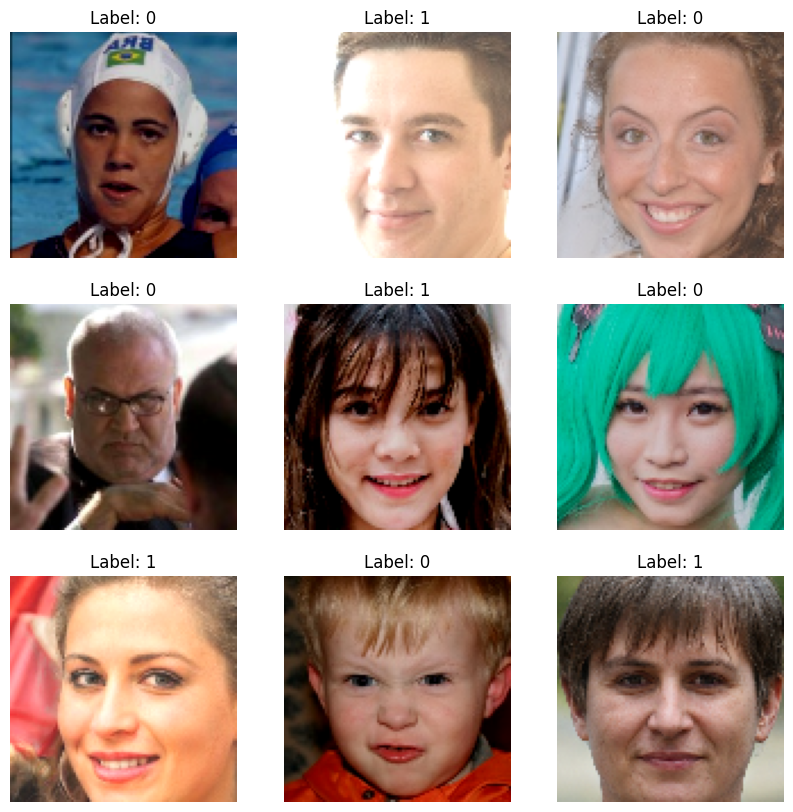

In [27]:
for images, labels in train_ds.take(1):
    images = images.numpy()
    labels = labels.numpy() # -> 1 - IA, 0 - Real
    
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i]) 
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

# Construção do Modelo Pré-treinado 1 - MobileNetV2

In [5]:
# --- Model (MobileNetV2 base) ---
base_model = applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/tmp/ipykernel_4525/2950774491.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_cp.weights.h5",
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3
)

In [7]:
# --- Train ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

Epoch 1/20
     22/Unknown 21s 286ms/step - accuracy: 0.5560 - loss: 0.8292

2025-07-05 20:21:14.975407: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/gustavo/Área de Trabalho/ML/ML_Final/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-07-05 20:21:23.624316: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 763ms/step - accuracy: 0.5572 - loss: 0.8280 - val_accuracy: 0.6667 - val_loss: 0.6728 - learning_rate: 1.0000e-04
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6231 - loss: 0.7447

2025-07-05 20:21:39.304791: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 639ms/step - accuracy: 0.6238 - loss: 0.7442 - val_accuracy: 0.6667 - val_loss: 0.5975 - learning_rate: 1.0000e-04
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 629ms/step - accuracy: 0.6751 - loss: 0.6545 - val_accuracy: 0.7067 - val_loss: 0.5884 - learning_rate: 1.0000e-04
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.6190 - loss: 0.6714

2025-07-05 20:22:10.898233: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 628ms/step - accuracy: 0.6191 - loss: 0.6718 - val_accuracy: 0.7267 - val_loss: 0.5715 - learning_rate: 1.0000e-04
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 631ms/step - accuracy: 0.6717 - loss: 0.6493 - val_accuracy: 0.6867 - val_loss: 0.5605 - learning_rate: 1.0000e-04
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 644ms/step - accuracy: 0.7039 - loss: 0.6059 - val_accuracy: 0.7200 - val_loss: 0.5599 - learning_rate: 1.0000e-04
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 560ms/step - accuracy: 0.6906 - loss: 0.6160 - val_accuracy: 0.6600 - val_loss: 0.6069 - learning_rate: 1.0000e-04
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 456ms/step - accuracy: 0.7108 - loss: 0.5856 - val_accuracy: 0.6467 - val_loss: 0.6131 - learning_rate: 1.0000e-04
Epoch 9/20


2025-07-05 20:23:10.692079: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 475ms/step - accuracy: 0.6923 - loss: 0.6090 - val_accuracy: 0.7267 - val_loss: 0.5575 - learning_rate: 1.0000e-04
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 493ms/step - accuracy: 0.6818 - loss: 0.5794 - val_accuracy: 0.7333 - val_loss: 0.5417 - learning_rate: 1.0000e-04
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 452ms/step - accuracy: 0.6376 - loss: 0.6411 - val_accuracy: 0.7200 - val_loss: 0.5769 - learning_rate: 1.0000e-04
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 442ms/step - accuracy: 0.6994 - loss: 0.5987 - val_accuracy: 0.7133 - val_loss: 0.5705 - learning_rate: 1.0000e-04
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - accuracy: 0.6942 - loss: 0.6063 - val_accuracy: 0.7267 - val_loss: 0.5546 - learning_rate: 1.0000e-04
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 506ms/step - accuracy: 0.7235 - loss: 0.5438 - val_accuracy: 0.8000 - val_loss: 0.5304 - learning_rate: 2.0000e-05
Epoch 15/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 517ms/step - accuracy

2025-07-05 20:24:47.087489: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - accuracy: 0.6898 - loss: 0.5678 - val_accuracy: 0.7467 - val_loss: 0.5523 - learning_rate: 2.0000e-05
Epoch 18/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 436ms/step - accuracy: 0.7074 - loss: 0.5606 - val_accuracy: 0.6933 - val_loss: 0.5700 - learning_rate: 2.0000e-05
Epoch 19/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 447ms/step - accuracy: 0.6815 - loss: 0.5764 - val_accuracy: 0.6867 - val_loss: 0.5627 - learning_rate: 4.0000e-06
Epoch 20/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 437ms/step - accuracy: 0.6844 - loss: 0.5990 - val_accuracy: 0.7267 - val_loss: 0.5623 - learning_rate: 4.0000e-06


# Resultados

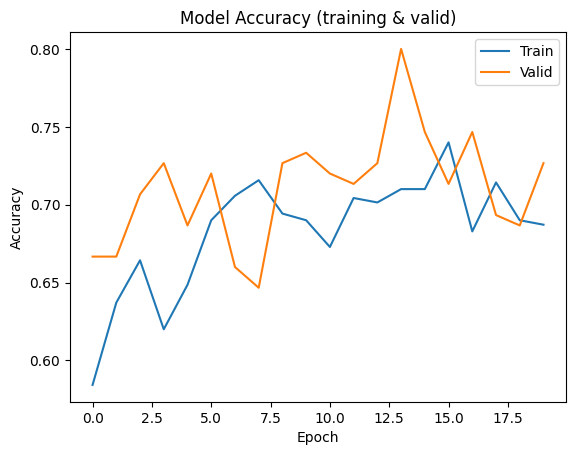

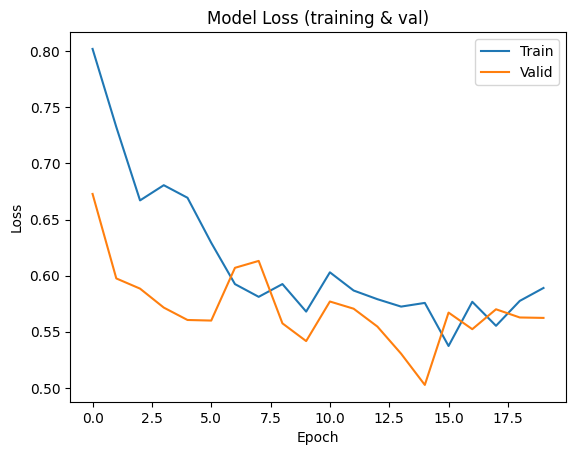

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

# Testando no Conjunto de Teste

In [9]:
loss, acc = model.evaluate(test_ds)
print(f"Test accuracy: {acc:.4f}")

5075/5075 ━━━━━━━━━━━━━━━━━━━━ 1193s 234ms/step - accuracy: 0.7255 - loss: 0.5436
Test accuracy: 0.7249


# Testando com o Modelo do Checkpoint Salvo

In [10]:
# --- Model (MobileNetV2 base) ---
base_model = applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Restore the weights
model.load_weights('model_cp.weights.h5')

/tmp/ipykernel_4525/60267402.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(
/home/gustavo/Área de Trabalho/ML/ML_Final/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

5075/5075 ━━━━━━━━━━━━━━━━━━━━ 1198s 234ms/step - accuracy: 0.7241 - loss: 0.5452
Test Loss: 0.5440405011177063
Test Accuracy: 0.7248849868774414


# Métricas

In [12]:
# predicted_labels = model.predict(test_ds)

5075/5075 ━━━━━━━━━━━━━━━━━━━━ 1193s 234ms/step


In [ ]:
# true_labels = test_ds.classes

# # matriz de confusão
# plt.figure(figsize = (8,5))
# sklearn.metrics.confusion_matrix(true_labels, predicted_labels.round())
# plt.show()

# Obter todas as imagens e rótulos reais
all_images = []
all_labels = []

for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

# Concatena tudo
X_test = np.concatenate(all_images)
y_true = np.concatenate(all_labels)

# Faz predições com o modelo (saída é probabilidade)
y_probs = model.predict(X_test)
y_pred = (y_probs > 0.5).astype(int).reshape(-1)

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão")
plt.show()

In [ ]:
#curva ROC
fpr, tpr, _ = roc_curve(y_true,  y_pred)
auc = roc_auc_score(y_true, y_pred)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))